### Splitting a countinous variable into a dichotomous one, with the help of the OR.

In [1]:
source("helpers.r")
library(tidyverse)

df <- get_training_df()
#df  <- df  %>% select(target, age)

min_age  <- min(df$age)
max_age  <- max(df$age)

max_abs_beta  <- 0

for(tao in seq(min_age, max_age, 1)) {
    
df_tmp  <- df %>%
  mutate(
    age_group = case_when(
      age <= tao ~ "not_old",
      ( age > tao)~ "old"
    )
  ) %>% 
  mutate(age_group= factor(age_group, levels = c("not_old", "old")))

OR_current  <- odds_ratio(df_tmp, "age_group")

if(is.nan(OR_current) || OR_current == 0) { next }    

abs_beta  <- log(OR_current) 
    
if(abs_beta > max_abs_beta) {
    max_abs_beta  <- abs_beta
    tao_max  <- tao
}
    
    
}

print(max_abs_beta)
print(tao_max)



#library(broom)
#fit  <- glm(target ~ age_group, data=df_tmp, family =binomial(link = "logit"))
#(fit_result  <- tidy(fit))

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_doubl

[1] 1.234744
[1] 70


Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


            
             not_old old
  no_disease     110   1
  disease        128   4

model,mean,median,sd
lg age,0.6225691,0.6314935,0.12343775
lg age group best,0.5108392,0.5000000,0.02639545
lg age group worse,0.5865926,0.5945305,0.13672035


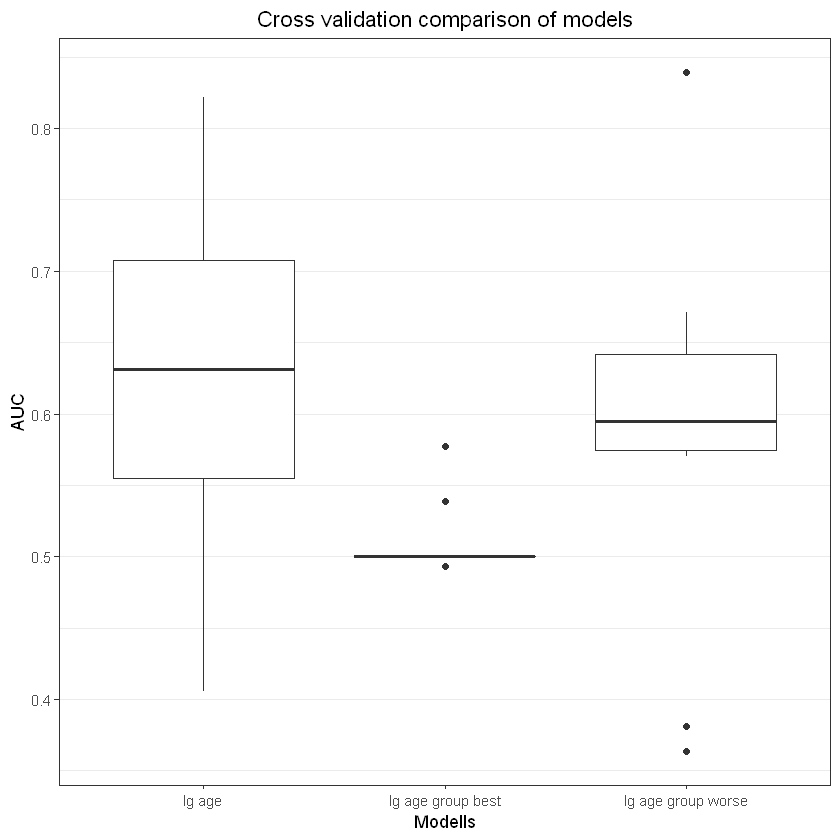

In [2]:
library(MLmetrics)
library(magrittr)

df <- get_training_df()

tao  <- 70
df_age_group  <- df %>%
  mutate(
    age_group = case_when(
      age <= tao ~ "not_old",
      ( age > tao)~ "old"
    )
  ) %>% 
  mutate(age_group= factor(age_group, levels = c("not_old", "old")))

table(df_age_group$target, df_age_group$age_group)

tao  <- 50
df_age_group_worse  <- df %>%
  mutate(
    age_group = case_when(
      age <= tao ~ "not_old",
      ( age > tao)~ "old"
    )
  ) %>% 
  mutate(age_group= factor(age_group, levels = c("not_old", "old")))

set.seed(25)
number_of_folds <- 10
folds <- createFolds(df$target, k = number_of_folds)

model_result <- tibble(model = vector("character"),
                       auc = vector("numeric"))
models <- c("lg age", "lg age group best", "lg age group worse")

for(model in models){
    for(fold_index in c(1:number_of_folds)){
        training <- df[-folds[[fold_index]],]
        test <- df[folds[[fold_index]],]

        y_true <- ifelse(test$target == "no_disease", 0, 1)

        if (model == "lg age") {
          fit <- glm(target ~ age, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }
        if (model == "lg age group best"){
                    training <- df_age_group[-folds[[fold_index]],]
        test <- df_age_group[folds[[fold_index]],]
          fit <- glm(target ~ age_group, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }
        if (model == "lg age group worse"){
            training <- df_age_group_worse[-folds[[fold_index]],]
            test <- df_age_group_worse[folds[[fold_index]],]
             fit <- glm(target ~ age_group, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }

        auc <- AUC(y_true = y_true, y_pred = y_probabilities)

        model_result %<>%
          add_row(model = model, auc = auc)

      }
}

model_result %>%
    group_by(model) %>%
    summarize(mean = mean(auc),
              median = median(auc),
              sd = sd(auc))

model_result %>%
    mutate(model = factor(model, levels = models)) %>%
    ggplot(aes(x = model, y = auc))+
    geom_boxplot() +
labs(
      x = "Modells",
      y = "AUC",
      title = "Cross validation comparison of models"
    ) + 
    theme_bw() + 
    theme(panel.grid.major.x = element_blank(),
          plot.title = element_text(hjust = 0.5)
          )

The best treshold calculatet through the highest absolut OR gives age 70, but a model using this age group variable performs very bad. This is because of the skewed distribution of cases within the different age groups. 

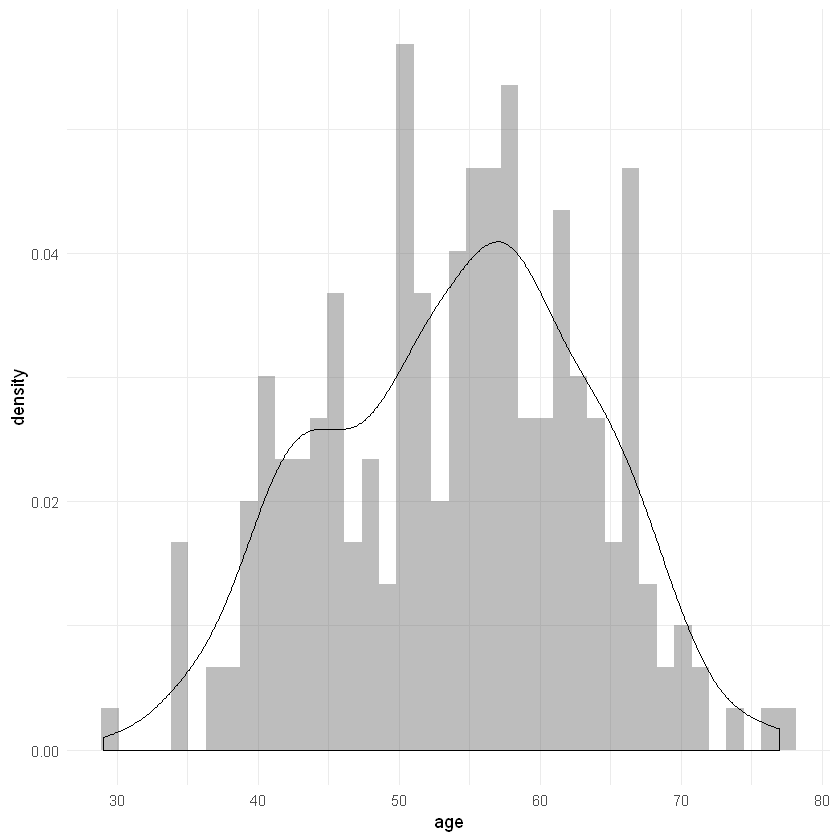

In [3]:
ggplot(df_age_group, aes(age)) + 
geom_histogram(aes(y=..density..), alpha = 0.4, bins = 40) + 
geom_density(alpha=.2) + 
theme_minimal()